In [41]:

import tensorflow as tf
import math
import numpy as np
import read_data
from sklearn.model_selection import train_test_split
import cv2 as cv
import matplotlib.pyplot as plt
import dlib

In [42]:
class FARE_Net:
    
    def __crop_and_resize_eye(self, image, eye_points : list):
        x_diff = abs(eye_points[0] - eye_points[2])
        y_diff = abs(eye_points[1] - eye_points[3])
        
        x_margin = ((60-x_diff) // 2) + 2
        y_margin = ((36-y_diff) // 2) + 1
        
        # Calculate bounding box for eye region
        min_x = min([eye_points[0],eye_points[2]]) - x_margin
        max_x = max([eye_points[0],eye_points[2]]) + x_margin
        min_y = min([eye_points[1],eye_points[3]]) - y_margin
        max_y = max([eye_points[1],eye_points[3]]) + y_margin

        # Extract eye region
        eye_image = image[min_y:max_y, min_x:max_x]

        # Resize eye image to 36x60
        eye_image = cv.resize(eye_image, (60, 36))

        return eye_image
  
    def __orthographic_projection(self, vector):
        # Assuming the vector is of the form (x, y, z)
        x, y, z = vector
        # Project onto the XY plane by dropping the z-coordinate
        return np.array([x, y])

    
    def __calculate_face_center(self, facial_landmarks):

        x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6 = facial_landmarks
        
        x_center = sum([x1, x2, x3, x4, x5, x6]) / 6
        y_center = sum([y1, y2, y3, y4, y5, y6]) / 6
        
        return int(x_center), int(y_center)
    
    def __get_face_image(self, image, landmarks, margin=40):
  
        # Extract facial landmark coordinates
        x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6 = landmarks
        
        # Calculate bounding box coordinates with margin clamping
        left = max(0, min(x1, x2, x3, x4, x5, x6) - margin)
        top = max(0, min(y1, y2, y3, y4, y5, y6) - margin)
        right = min(image.shape[1], max(x1, x2, x3, x4, x5, x6) + margin)
        bottom = min(image.shape[0], max(y1, y2, y3, y4, y5, y6) + margin)
        
        # Crop the image based on clamped bounding box
        cropped_image = image[top:bottom, left:right]
        
        # Resize the image to 224x224 pixels (optional)
        resized_image = cv.resize(cropped_image, (224, 224))
        
        return resized_image
    
    def __get_facial_landmarks(self,image):
        detector = dlib.get_frontal_face_detector()
        predictor = dlib.shape_predictor('Face Landmarks Predictor.dat')
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        faces = detector(gray)
        
        face = faces[0]
        
        landmarks = predictor(gray, face)
        
        points = []
        
        for i in  [36, 39, 42, 45, 48, 54] :
            points.append(landmarks.part(i).x)
            points.append(landmarks.part(i).y)
        
        return points
    
    def __angular_err(self, v1, v2):
        v1xv2 = tf.reduce_sum(v1*v2,1)
        v1_len = tf.cast(tf.sqrt(tf.reduce_sum(tf.square(v1), 1)),dtype=tf.float32)
        v2_len = tf.cast(tf.sqrt(tf.reduce_sum(tf.square(v2), 1)),dtype=tf.float32)
        
        val = tf.minimum( v1xv2/((v1_len* v2_len ) + 1e-10), 0.999999)
    
        degree = tf.acos(val)
        return degree * 180/ math.pi
    
    def __init__(self, far_net_model_path, e_net_model_path):
        self.far_net = tf.keras.models.load_model(far_net_model_path)
        self.e_net = tf.keras.models.load_model(e_net_model_path)
        
    def predict(self, data) :
        gaze_directions = self.far_net(data)
        probabilities = self.e_net(data[0:2])
        
        choosed_gaze = []
        choosed = []
        
        for i, prob in enumerate(probabilities):
            if prob[0] <= prob[1]:
                choosed_gaze.append(gaze_directions[i][:3])
                choosed.append("Left")
            else :
                choosed_gaze.append(gaze_directions[i][3:])
                choosed.append("Right")
        
        return choosed_gaze, choosed
    
    def validate(self, data, labels):
        print("Validating...")
        gazes, chooseds = self.predict(data=data)
        
        new_labels = []
        
        for choosed, label in zip(chooseds, labels):
            
            if choosed == "Left" :
                new_labels.append(label[:3])
            else :
                new_labels.append(label[3:])
                
                
        angular_errors = self.__angular_err(gazes, tf.cast(np.array(new_labels, dtype=float), dtype=tf.float32))
            
        print(f"Mean Angular Error => {tf.reduce_mean(angular_errors)}")
    
    def __get_image_from_camera(self):
        video = cv.VideoCapture(1) 
        a = 0
        while True:
            a = a + 1
            check, frame = video.read()
            key = cv.waitKey(1)
            if a == 60 :
                break   

        video.release()
        cv.destroyAllWindows()
        
        return frame
    
    def __get_image_from_path(self, path):
        img = cv.imread(path)
        
        return img
        
        
    def visualize_gaze(self, path=None) :
        
        if path == None :
            raw_face_img = self.__get_image_from_camera()
        else :
            raw_face_img = self.__get_image_from_path(path)

        raw_img_landmarks = self.__get_facial_landmarks(raw_face_img)

        x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6 = raw_img_landmarks
        
        r_center_x = (x1 + x2) // 2
        r_center_y = (y1 + y2) // 2
        
        l_center_x = (x3 + x4) // 2
        l_center_y = (y3 + y4) // 2
        

        r_eye_img = self.__crop_and_resize_eye(raw_face_img,[x1, y1, x2, y2])
        r_eye_img = cv.cvtColor(r_eye_img, cv.COLOR_RGB2GRAY)
        r_eye_img = r_eye_img / 255.0

        l_eye_img = self.__crop_and_resize_eye(raw_face_img,[x3, y3, x4, y4])
        l_eye_img = cv.cvtColor(l_eye_img, cv.COLOR_RGB2GRAY)
        l_eye_img = l_eye_img / 255.0
        
        face_img = self.__get_face_image(raw_face_img,raw_img_landmarks)
        face_img = face_img / 255.0

        gaze, choosed = self.predict([np.array([l_eye_img]), np.array([r_eye_img]), np.array([face_img])])

        if choosed[0] == "Left" :
            center_x =  l_center_x
            center_y = l_center_y
        else :
            center_x =  r_center_x
            center_y = r_center_y
        
        magnitude = np.linalg.norm(gaze[0])
        normalized_vector = gaze[0] / magnitude

        scaling_factor = 200  
        end_x = center_x - normalized_vector[0] * scaling_factor
        end_y = center_y + normalized_vector[1] * scaling_factor 

        rgb_img = cv.cvtColor(raw_face_img,cv.COLOR_BGR2RGB)

        plt.figure(figsize=(8,6))
        plt.imshow(rgb_img)
        plt.plot([end_x,center_x], [end_y,center_y], 'g-', linewidth=2) 
        plt.title(f'Gaze Direction Visualization - {choosed[0]} Eye')
        plt.show()
            
                

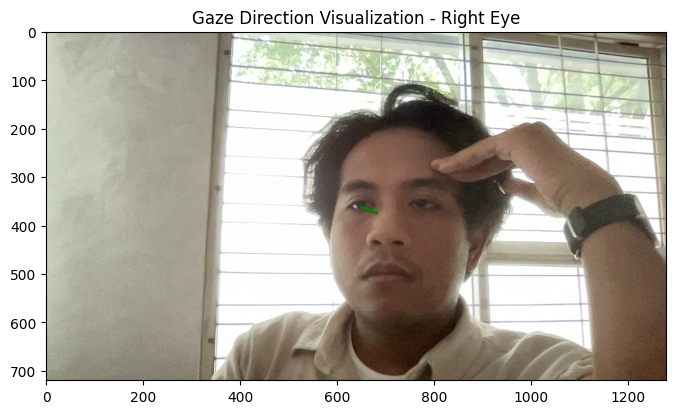

In [43]:
path = "log/enhanced2/1"

fare_net = FARE_Net(far_net_model_path=f"{path}/far_net_model.keras", e_net_model_path=f"{path}/e_net_model.keras")

fare_net.visualize_gaze()